In [1]:
# Python SQL toolkit and Object Relational Mapper
import numpy as np
import pandas as pd
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect
from config import pgkey
from sklearn.neighbors import KNeighborsClassifier
import os

In [2]:
stations = pd.read_csv("../Data/Nice_Ride_2017_Station_Locations.csv")
stations_df = pd.DataFrame(stations)
stations_df.head()

,ID,Number,Name,Latitude,Longitude,Total docks
0,1,30000,100 Main Street SE,44.984892,-93.256551,27
1,2,30001,25th Street & 33rd Ave S,44.957341,-93.223374,15
2,3,30002,Riverside Ave & 23rd Ave S,44.967115,-93.240149,15
3,4,30003,Plymouth Ave N & N Oliver Ave,44.991412,-93.306269,15
4,5,30004,11th Street & Hennepin,44.975340,-93.278690,23


In [3]:
bikes = pd.read_csv("../Data/Nice_ride_trip_history_2017_season.csv", low_memory=False)
bikes_df = pd.DataFrame(bikes)
bikes_df['Start Date'] = pd.to_datetime(bikes_df['Start Date'])
bikes_df.head()

,ID,Start Date,Start Time,Start station,Start station number,End Date,End Time,End station,End station number,Account type,Total duration (Seconds)
0,1,2017-11-05,21:45,Hennepin Ave & S Washington Ave,30184,11/5/17,22:02,Logan Park,30104,Member,1048
1,2,2017-11-05,22:45,Broadway Street N & 4th Street E,30122,11/5/17,22:26,Broadway Street N & 4th Street E,30122,Member,2513
2,3,2017-11-05,23:45,Dale Street & Grand Ave.,30106,11/5/17,22:13,N Milton Street & Summit Ave,30101,Member,1817
3,4,2017-11-05,0:45,Weisman Art Museum,30183,11/5/17,22:05,22nd Ave S & Franklin Ave,30014,Casual,1399
4,5,2017-11-05,1:45,South 2nd Street & 3rd Ave S,30030,11/5/17,21:44,6th Ave SE & University Ave,30088,Member,370


In [4]:
weather = pd.read_csv("../Data/WeatherDailyMinneapolis2017.csv", low_memory=False)
weather_df = pd.DataFrame(weather)
col = weather_df.loc[: , "TMAX":"TMIN"]
weather_df['TAVG'] = col.mean(axis=1)
weather_df.head()


,ID,STATION,NAME,DATE,PRCP,TMAX,TMIN,TAVG
0,1,USC00218450,"UNIVERSITY OF MN ST. PAUL, MN US",1/1/17,0.00,26,18,22.0
1,2,USC00218450,"UNIVERSITY OF MN ST. PAUL, MN US",1/2/17,0.00,31,20,25.5
2,3,USC00218450,"UNIVERSITY OF MN ST. PAUL, MN US",1/3/17,0.01,30,25,27.5
3,4,USC00218450,"UNIVERSITY OF MN ST. PAUL, MN US",1/4/17,0.00,25,-6,9.5
4,5,USC00218450,"UNIVERSITY OF MN ST. PAUL, MN US",1/5/17,0.01,2,-8,-3.0


In [5]:
num_stations = bikes_df['Start station'].nunique()
print(num_stations)

202


In [6]:
weather_clean = weather_df[['DATE', 'PRCP', 'TMAX', 'TMIN', 'TAVG']]
weather_clean = weather_clean.rename(columns={'DATE':'Start Date'})
weather_clean.head()
weather_clean['Start Date']=pd.to_datetime(weather_clean['Start Date'])
BigBikes = pd.merge(bikes_df, weather_clean, on="Start Date", how="left")
BigBikes.head()

,ID,Start Date,Start Time,Start station,Start station number,End Date,End Time,End station,End station number,Account type,Total duration (Seconds),PRCP,TMAX,TMIN,TAVG
0,1,2017-11-05,21:45,Hennepin Ave & S Washington Ave,30184,11/5/17,22:02,Logan Park,30104,Member,1048,0.1,41,33,37.0
1,2,2017-11-05,22:45,Broadway Street N & 4th Street E,30122,11/5/17,22:26,Broadway Street N & 4th Street E,30122,Member,2513,0.1,41,33,37.0
2,3,2017-11-05,23:45,Dale Street & Grand Ave.,30106,11/5/17,22:13,N Milton Street & Summit Ave,30101,Member,1817,0.1,41,33,37.0
3,4,2017-11-05,0:45,Weisman Art Museum,30183,11/5/17,22:05,22nd Ave S & Franklin Ave,30014,Casual,1399,0.1,41,33,37.0
4,5,2017-11-05,1:45,South 2nd Street & 3rd Ave S,30030,11/5/17,21:44,6th Ave SE & University Ave,30088,Member,370,0.1,41,33,37.0


In [7]:
BigBikes = BigBikes.reset_index()
#BigBikes=BigBikes.set_index('Start Date')
dates = BigBikes['Start Date'].unique()
Accounts = ['Member', 'Casual']
BikesArray = []


for date in dates:
    UserArray = []
    UserArray.append(date)
    Members = BigBikes.loc[(BigBikes['Start Date']==date) & (BigBikes['Account type'] == 'Member') ]
    NumMembers = Members['ID'].count()
    UserArray.append(NumMembers)
    Casual = BigBikes.loc[(BigBikes['Start Date']==date) & (BigBikes['Account type'] == 'Casual') ]
    NumCasual = Casual['ID'].count()
    UserArray.append(NumCasual)
    total = NumMembers + NumCasual
    UserArray.append(total)
    BikesArray.append(UserArray)
    
    

    

In [8]:

datesDF = pd.DataFrame(BikesArray, columns = ['Date', 'TotalMemberTrips','TotalCasualTrips', 'TotalTrips'])
datesDF.head()

,Date,TotalMemberTrips,TotalCasualTrips,TotalTrips
0,2017-11-05,242,40,282
1,2017-11-04,233,91,324
2,2017-11-03,487,65,552
3,2017-11-02,625,40,665
4,2017-11-01,495,26,521


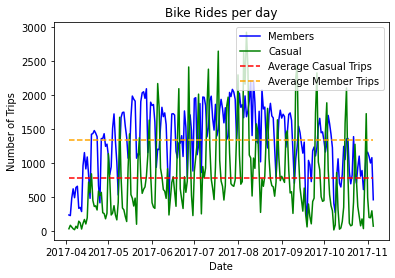

In [27]:
#Plot trips per day
import matplotlib.pyplot as plt
x = datesDF['Date'].sort_values()
y1 = datesDF['TotalMemberTrips']
y2 = datesDF['TotalCasualTrips']
y3 = datesDF['TotalTrips']
ymean = [np.mean(y3)]*len(x)
y1mean = [np.mean(y1)]*len(x)
y2mean = [np.mean(y2)]*len(x)
plt.plot(x, y1, color = 'blue', label = 'Members')
plt.plot(x, y2, color = 'green', label = 'Casual')
plt.plot(x, y2mean, color = 'red', label='Average Casual Trips', linestyle='--')
plt.plot(x, y1mean, color = 'orange', label='Average Member Trips', linestyle='--')
plt.title('Bike Rides per day')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
# Make a legend
plt.legend(loc='upper right')

plt.show()

In [38]:
TotalDailyTrips = datesDF['TotalTrips']
meanTrips = TotalDailyTrips.mean()
print(meanTrips)
TripStatus = []
for trips in TotalDailyTrips:
    if trips > meanTrips:
        TripStatus.append(1)
    else:
        TripStatus.append(0)
datesDF['TripStatus'] = TripStatus
datesDF.head()

2123.115207373272


,Date,TotalMemberTrips,TotalCasualTrips,TotalTrips,TripStatus
0,2017-11-05,242,40,282,0
1,2017-11-04,233,91,324,0
2,2017-11-03,487,65,552,0
3,2017-11-02,625,40,665,0
4,2017-11-01,495,26,521,0


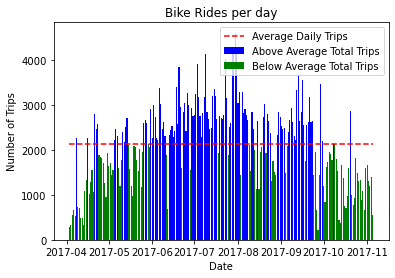

In [40]:
mask1 = y3 > meanTrips
mask2 = y3 <= meanTrips
plt.bar(x[mask1], y3[mask1], color = 'blue', label = 'Above Average Total Trips')
plt.bar(x[mask2], y3[mask2], color = 'green', label = 'Below Average Total Trips')
plt.plot(x, ymean, color = 'red', label='Average Daily Trips', linestyle='--')
plt.title('Bike Rides per day')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
# Make a legend
plt.legend(loc='upper right')

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

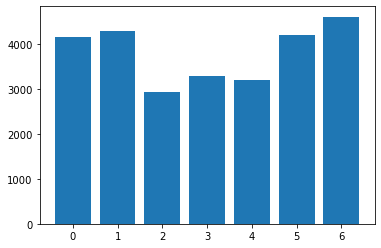

In [17]:
# Calculate casual users by day of week
xvalues = datesDF['Date'].dt.dayofweek
plt.bar(xvalues, y3)
plt.show

In [ ]:
DayBikes = datesDF

In [ ]:
Members_Group = BigBikes.groupby(["Account type"])
Members_Group.value counts()